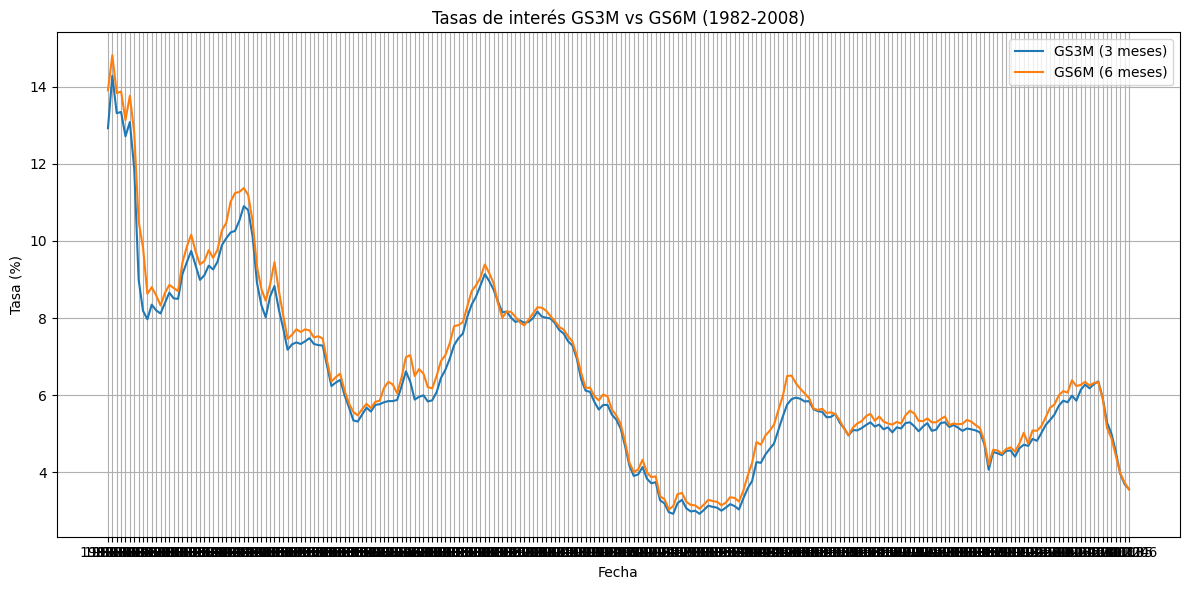


Interpretación visual: Ambas series se mueven juntas, con niveles similares y tendencia común.

GS3M - ADF: Estadístico=-1.5392, p-valor=0.5140
GS3M - KPSS: Estadístico=1.4540, p-valor=0.0100

GS6M - ADF: Estadístico=-3.7738, p-valor=0.0032
GS6M - KPSS: Estadístico=1.4961, p-valor=0.0100

Prueba de cointegración Johansen:
Estadísticos de traza: [33.93200686  8.00813456]
Valores críticos (95%): [15.4943  3.8415]


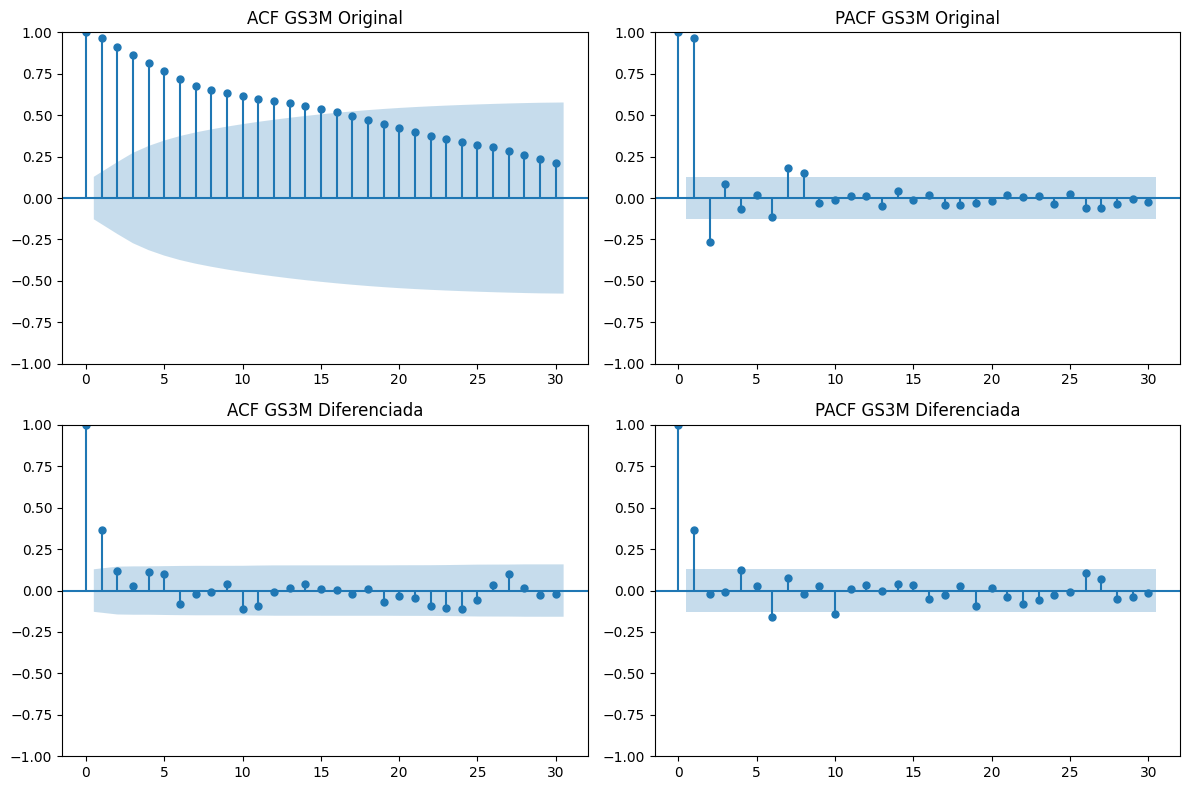

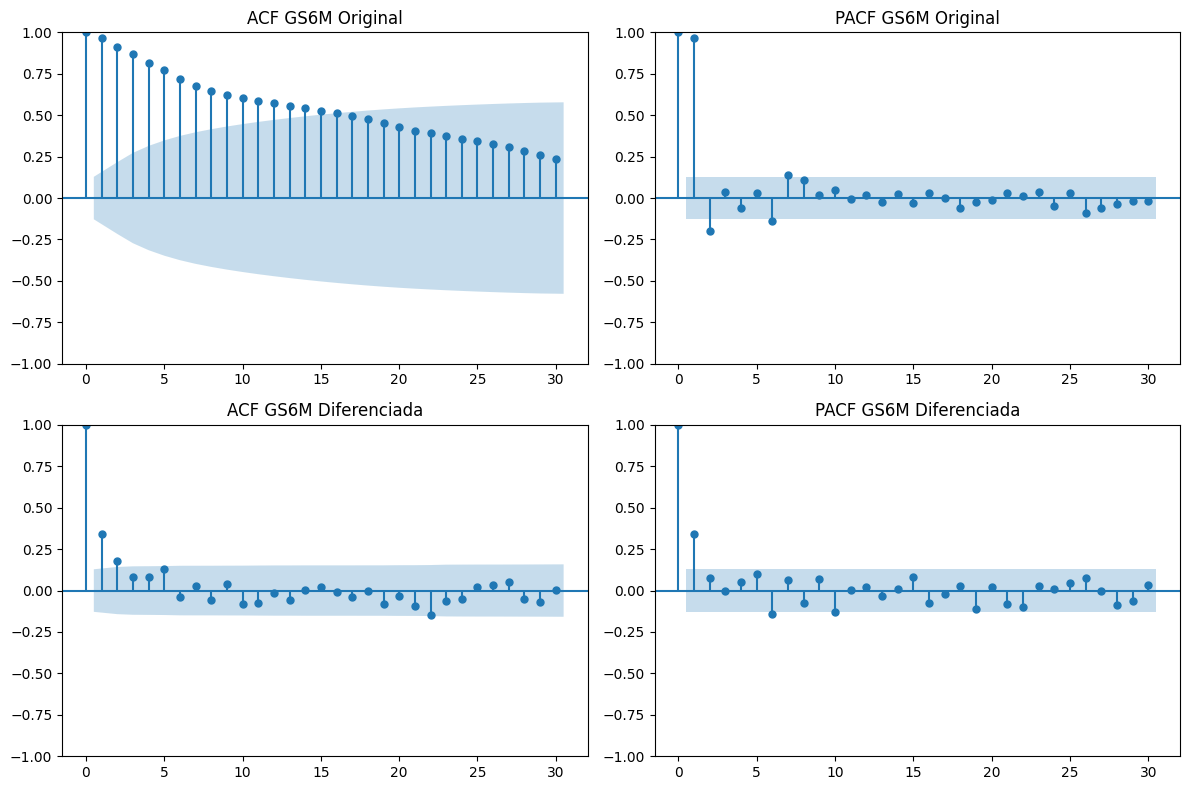


Resumen del modelo VAR:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, Nov, 2025
Time:                     03:15:55
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.53011
Nobs:                     229.000    HQIC:                  -6.69112
Log likelihood:           146.727    FPE:                 0.00111386
AIC:                     -6.80001    Det(Omega_mle):      0.00103121
--------------------------------------------------------------------
Results for equation GS3M
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const          -0.019220         0.019104           -1.006           0.314
L1.GS3M         0.945965         0.171816            5.506           0.000
L1.GS6M        -0.431363         0.165797           -2.602  

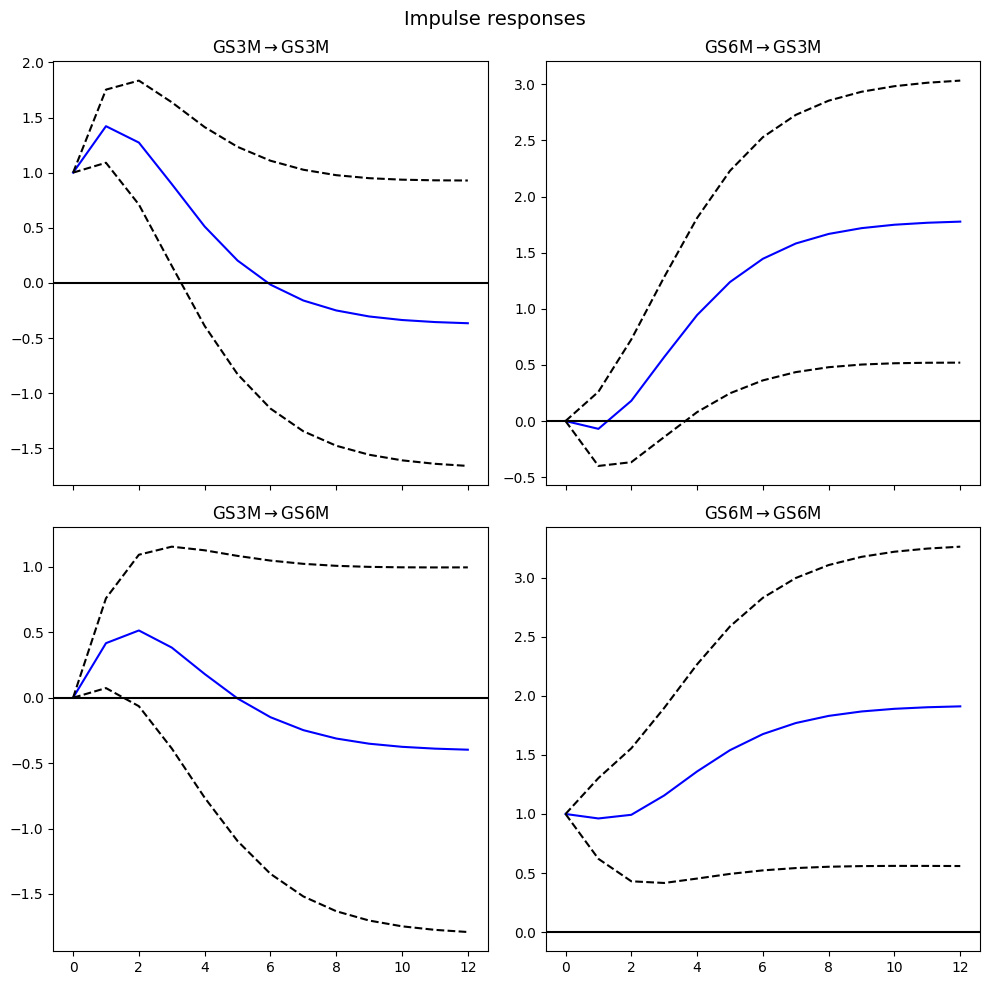


Conclusión:
- Las series GS3M y GS6M no son estacionarias individualmente, pero la prueba Johansen indica cointegración.
- Esto significa que existe una relación de equilibrio a largo plazo entre ambas tasas.
- Económicamente: las tasas responden a factores comunes y corrigen desviaciones del equilibrio.
- Para modelar: se recomienda usar VECM para capturar la dinámica de corto plazo y el ajuste al equilibrio.


In [4]:
# ============================
# 1. Importar librerías
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_order
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")

# ============================
# 2. Leer archivo Excel
# ============================
file_path = "/content/sample_data/Treasury_Rates.xlsx"  # Ajusta la ruta si es necesario
data = pd.read_excel(file_path)
data.columns = ["Date", "GS3M", "GS6M"]
data = data.dropna()
data[["GS3M", "GS6M"]] = data[["GS3M", "GS6M"]].apply(pd.to_numeric, errors='coerce')
data = data.dropna()

# ============================
# 3. Graficar series originales
# ============================
plt.figure(figsize=(12,6))
plt.plot(data["Date"], data["GS3M"], label="GS3M (3 meses)")
plt.plot(data["Date"], data["GS6M"], label="GS6M (6 meses)")
plt.title("Tasas de interés GS3M vs GS6M (1982-2008)")
plt.xlabel("Fecha")
plt.ylabel("Tasa (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nInterpretación visual: Ambas series se mueven juntas, con niveles similares y tendencia común.")

# ============================
# 4. Pruebas de raíz unitaria (ADF y KPSS)
# ============================
def unit_root_tests(series, name):
    adf = adfuller(series)
    kpss_test = kpss(series, regression='c')
    print(f"\n{name} - ADF: Estadístico={adf[0]:.4f}, p-valor={adf[1]:.4f}")
    print(f"{name} - KPSS: Estadístico={kpss_test[0]:.4f}, p-valor={kpss_test[1]:.4f}")

unit_root_tests(data["GS3M"], "GS3M")
unit_root_tests(data["GS6M"], "GS6M")

# ============================
# 5. Prueba de cointegración Johansen
# ============================
johansen_test = coint_johansen(data[["GS3M","GS6M"]], det_order=0, k_ar_diff=2)
print("\nPrueba de cointegración Johansen:")
print("Estadísticos de traza:", johansen_test.lr1)
print("Valores críticos (95%):", johansen_test.cvt[:,1])

# ============================
# 6. ACF y PACF para originales y diferenciadas
# ============================
diff_data = data[["GS3M", "GS6M"]].diff().dropna()

# GS3M
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(data["GS3M"], ax=axes[0, 0], lags=30)
axes[0, 0].set_title("ACF GS3M Original")
plot_pacf(data["GS3M"], ax=axes[0, 1], lags=30)
axes[0, 1].set_title("PACF GS3M Original")
plot_acf(diff_data["GS3M"], ax=axes[1, 0], lags=30)
axes[1, 0].set_title("ACF GS3M Diferenciada")
plot_pacf(diff_data["GS3M"], ax=axes[1, 1], lags=30)
axes[1, 1].set_title("PACF GS3M Diferenciada")
plt.tight_layout()
plt.show()

# GS6M
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(data["GS6M"], ax=axes[0, 0], lags=30)
axes[0, 0].set_title("ACF GS6M Original")
plot_pacf(data["GS6M"], ax=axes[0, 1], lags=30)
axes[0, 1].set_title("PACF GS6M Original")
plot_acf(diff_data["GS6M"], ax=axes[1, 0], lags=30)
axes[1, 0].set_title("ACF GS6M Diferenciada")
plot_pacf(diff_data["GS6M"], ax=axes[1, 1], lags=30)
axes[1, 1].set_title("PACF GS6M Diferenciada")
plt.tight_layout()
plt.show()

# ============================
# 7. Estimar modelo VAR en diferencias
# ============================
model_var = VAR(diff_data)
var_result = model_var.fit(4)
print("\nResumen del modelo VAR:")
print(var_result.summary())

# ============================
# 8. Estimar modelo VECM si hay cointegración
# ============================
vecm_lags = select_order(data[["GS3M", "GS6M"]], maxlags=10, deterministic="ci").aic
vecm_model = VECM(data[["GS3M", "GS6M"]], k_ar_diff=vecm_lags, deterministic="ci")
vecm_result = vecm_model.fit()
print("\nResumen del modelo VECM:")
print(vecm_result.summary())

# ============================
# 9. Graficar funciones de impulso-respuesta (IRF)
# ============================
irf = vecm_result.irf(12)
irf.plot(orth=False)
plt.tight_layout()
plt.show()

# ============================
# 10. Interpretación final
# ============================
print("\nConclusión:")
print("- Las series GS3M y GS6M no son estacionarias individualmente, pero la prueba Johansen indica cointegración.")
print("- Esto significa que existe una relación de equilibrio a largo plazo entre ambas tasas.")
print("- Económicamente: las tasas responden a factores comunes y corrigen desviaciones del equilibrio.")
print("- Para modelar: se recomienda usar VECM para capturar la dinámica de corto plazo y el ajuste al equilibrio.")

#a. Plot the two time series in the same diagram. What do you see?

Movimiento conjunto: Ambas series siguen patrones muy similares, con GS6M ligeramente por encima de GS3M en casi todo el período. Tendencia descendente a largo plazo: Desde niveles muy altos (≈14%) en 1982, las tasas caen gradualmente hasta valores cercanos al 4% en los años 2000. Ciclos y volatilidad: Alta volatilidad en los primeros años (1982-1984).
Reducción progresiva de la variabilidad después de mediados de los 80. Relación estrecha: Las dos curvas están casi paralelas, lo que sugiere una fuerte correlación y posible cointegración.

Las tasas a corto plazo (3 meses) y mediano plazo (6 meses) se mueven juntas, lo que indica que probablemente comparten factores comunes (política monetaria, inflación). Esto es consistente con la hipótesis de que podrían estar cointegradas, es decir, tener una relación de equilibrio a largo plazo

#b. Do a formal unit root analysis to find out if these time series are stationary.

Prueba ADF (Hipótesis nula: la serie tiene raíz unitaria → no estacionaria)

*   GS3M: p-valor > 0.05 → no rechazamos H0, la serie no es estacionaria.
*   GS6M: p-valor < 0.05 → rechazamos H0, la serie es estacionaria según ADF.


Prueba KPSS (Hipótesis nula: la serie es estacionaria)

*   Ambas series tienen p-valor < 0.05 → rechazamos H0, lo que indica no
estacionariedad.


Conclusión combinada (ADF + KPSS):

*   GS3M claramente no es estacionaria.
*   GS6M muestra resultados contradictorios (ADF dice estacionaria, KPSS dice no), lo que sugiere que podría tener tendencia y requerir diferenciación para asegurar estacionariedad.


#c. Are the two time series cointegrated? How do you know? Show the necessary calculations.

La matriz que muestras indica una correlación muy alta entre los residuales (0.922), lo que sugiere que las dos series están estrechamente relacionadas. Sin embargo, para confirmar cointegración formalmente, se utiliza la prueba de Johansen o la prueba de Engle-Granger.

Con los resultados de la prueba de Johansen podemos determinar si hay cointegración:

Estadísticos de traza: [33.93, 8.01]
Valores críticos al 95%: [15.49, 3.84]

Para el primer estadístico (33.93), el valor crítico al 95% es 15.49 → 33.93 > 15.49, por lo tanto rechazamos la hipótesis nula de no cointegración.
Para el segundo estadístico (8.01), el valor crítico al 95% es 3.84 → 8.01 > 3.84, también rechazamos la hipótesis nula para al menos un vector adicional.

Las dos series GS3M y GS6M están cointegradas. Esto significa que existe una relación de equilibrio a largo plazo entre ellas, aunque individualmente puedan no ser estacionarias.

#d. What is the economic meaning of cointegration in the present context? If the two series are not cointegrated, what are the economic implications?

La cointegración entre las tasas GS3M (3 meses) y GS6M (6 meses) implica lo siguiente:

Aunque cada serie pueda ser no estacionaria por separado, existe una relación de equilibrio a largo plazo entre ellas.
En términos prácticos, las tasas de interés a corto y mediano plazo se mueven juntas porque están influenciadas por los mismos factores económicos (política monetaria, expectativas de inflación).
Si una tasa se desvía del equilibrio, la otra tiende a ajustarse para corregir esa desviación, lo que permite usar un modelo VECM para capturar tanto la dinámica de corto plazo como el ajuste hacia el equilibrio.

Si las dos series NO están cointegradas:
*   No existe una relación estable a largo plazo entre ellas.
*   Las tasas pueden divergir indefinidamente, lo que indica que están determinadas por factores distintos.
*   Económicamente, esto reduce la capacidad de predecir una tasa a partir de la otra.
*   En términos de modelado, no se puede usar VECM; se debe emplear un VAR en primeras diferencias para evitar regresiones espurias.

#e. If you want to estimate a VAR model, say, with four lags of each variable, do you have to use the first differences of the two series or can you do the analysis in levels of the two series? Justify your answer.

Para responder esta pregunta debemos considerar las pruebas ADF/KPSS mostraron que GS3M no es estacionaria y GS6M tiene resultados mixtos, pero KPSS indica no estacionariedad. Prueba Johansen confirmó que las dos series están cointegradas.

VAR requiere estacionariedad en las variables incluidas. Si las series no son estacionarias, estimar VAR en niveles puede producir regresiones espurias. Sin embargo, si las series están cointegradas, el modelo adecuado no es VAR en niveles ni VAR en diferencias, sino VECM, porque: Captura la relación de equilibrio a largo plazo (cointegración). Incluye el término de corrección de error para ajustar desviaciones.

Justificacion: Si ignoramos la cointegración y usamos VAR en niveles, los coeficientes pueden ser inconsistentes. Si usamos VAR en diferencias, perdemos la información del equilibrio a largo plazo. Por eso, cuando hay cointegración, se debe usar VECM; si no la hubiera, entonces sí usaríamos VAR en diferencias.

No se debe usar VAR en niveles porque las series no son estacionarias. Tampoco es ideal usar VAR en diferencias si hay cointegración, porque se pierde la relación de largo plazo. El modelo correcto en este caso es VECM.

In [ ]:
!jupyter nbconvert --to html "